In [2]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

import lsst.afw.math as afwMath
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage

import diffimTests as dit

In [3]:
def getSpatialParameters(nKernelParams, func):
    """Get basic spatial parameters list

    You may wish to tweak it up for specific cases (especially the lower order terms)
    """
    nCoeff = func.getNParameters()
    spParams = [[0.0]*nCoeff]*nKernelParams
    for kernelTermInd in range(nKernelParams):
        spParams[kernelTermInd][0] = 1.0
        spParams[kernelTermInd][1:3] = [1.0e-3]*len(spParams[kernelTermInd][1:3])
        spParams[kernelTermInd][3:6] = [1.0e-6]*len(spParams[kernelTermInd][3:6])
        spParams[kernelTermInd][6:10] = [1.0e-9]*len(spParams[kernelTermInd][6:10])
    return spParams

In [4]:
kSize = 19
spOrder = 3

kernelList = afwMath.KernelList()
for ctrX in range(kSize):
    for ctrY in range(kSize):
        kernel = afwMath.DeltaFunctionKernel(kSize, kSize, afwGeom.Point2I(ctrX, ctrY))
        kernelList.append(kernel)

In [5]:
polyFunc = afwMath.PolynomialFunction2D(spOrder)
kernel = afwMath.LinearCombinationKernel(kernelList, polyFunc)
spParams = getSpatialParameters(len(kernelList), polyFunc)
kernel.setSpatialParameters(spParams)

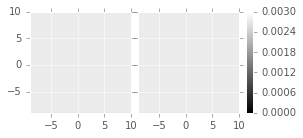

In [6]:
kimg = afwImage.ImageD(kernel.getDimensions())
kernel.computeImage(kimg, True, 10., 10.)

reload(dit)
dit.plotImageGrid((kimg,kimg), clim=(0., 0.003))

OK, look at testSVLinearCombinationKernel in ~/lsstsw/build/afw/tests/kernel.py

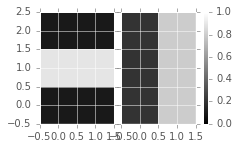

In [7]:
kWidth = 3
kHeight = 2

# create image arrays for the basis kernels
basisImArrList = []
imArr = np.zeros((kWidth, kHeight), dtype=float)
imArr += 0.1
imArr[kWidth//2, :] = 0.9
imArr /= imArr.sum()
basisImArrList.append(imArr)
imArr = np.zeros((kWidth, kHeight), dtype=float)
imArr += 0.2
imArr[:, kHeight//2] = 0.8
imArr /= imArr.sum()
basisImArrList.append(imArr)

reload(dit)
dit.plotImageGrid(basisImArrList, clim=(0,1))

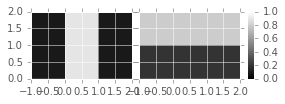

In [8]:
# create a list of basis kernels from the images
basisKernelList = afwMath.KernelList()
for basisImArr in basisImArrList:
    basisImage = afwImage.makeImageFromArray(basisImArr.transpose().copy())
    kernel = afwMath.FixedKernel(basisImage)
    basisKernelList.append(kernel)

reload(dit)
dit.plotImageGrid(basisKernelList, clim=(0,1))

[0.0, 2.2000000000000002, 3.0, 5.2000000000000011, 2.6000000000000005]


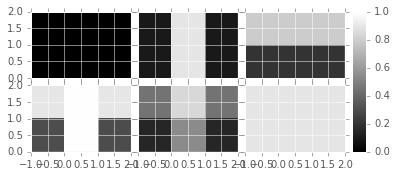

In [19]:
spFunc = afwMath.PolynomialFunction2D(1)

# spatial parameters are a list of entries, one per kernel parameter;
# each entry is a list of spatial parameters for a given kernel basis: 
# polynomial coefficients (const, x, y, x^2, xy, y^2...); length must be one of 1, 3, 6, 10, 15... 
sParams = (
    (0.0, 1.0, 0.0),
    (0.0, 0.0, 1.0),
)

kernel = afwMath.LinearCombinationKernel(basisKernelList, spFunc)
kernel.setSpatialParameters(sParams)
kImages = []
for colPos, rowPos, coeff0, coeff1 in [
    (0.0, 0.0, 0.0, 0.0),
    (1.0, 0.0, 1.0, 0.0),
    (0.0, 1.0, 0.0, 1.0),
    (1.0, 1.0, 1.0, 1.0),
    (0.5, 0.5, 0.5, 0.5),]:
    kImage = afwImage.ImageD(afwGeom.Extent2I(kWidth, kHeight))
    kernel.computeImage(kImage, False, colPos, rowPos)
    kImages.append(kImage)
    kImArr = kImage.getArray().transpose()
    refKImArr = (basisImArrList[0] * coeff0) + (basisImArrList[1] * coeff1)
    
print [kim.getArray().sum() for kim in kImages]

reload(dit)
dit.plotImageGrid(kImages, clim=(0,1))

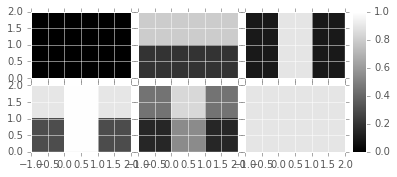

In [10]:
sParams = (
    (0.0, 0.0, 1.0),
    (0.0, 1.0, 0.0),
)
kernel.setSpatialParameters(sParams)

kImages = []
for colPos, rowPos, coeff0, coeff1 in [
    (0.0, 0.0, 0.0, 0.0),
    (1.0, 0.0, 1.0, 0.0),
    (0.0, 1.0, 0.0, 1.0),
    (1.0, 1.0, 1.0, 1.0),
    (0.5, 0.5, 0.5, 0.5),]:
    kImage = afwImage.ImageD(afwGeom.Extent2I(kWidth, kHeight))
    kernel.computeImage(kImage, False, colPos, rowPos)
    kImages.append(kImage)
    kImArr = kImage.getArray().transpose()
    refKImArr = (basisImArrList[0] * coeff0) + (basisImArrList[1] * coeff1)
    
print [kim.getArray().sum() for kim in kImages]

reload(dit)
dit.plotImageGrid(kImages, clim=(0,1))

It looks like a LanczosFunction2D is what we could use to "interpolate" between a grid of kernels.
Let's see at least if it will work.

We will need to set a separate LanczosFunction2D for each kernel, centered on the center location upon which the grid was calculated (the first param of LanczosFunction2D() is 'n' which describes the spatial scale)

[2.2000000000000002, 3.0]
[2.2000000000000002, 7.9017866906406836e-33, 7.9017866906406836e-33, 3.0, 0.85412972358973682]


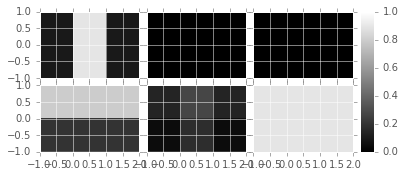

In [18]:
sParams = afwMath.Function2DList()
sParams.append(afwMath.LanczosFunction2D(1, 0., 0.))
sParams.append(afwMath.LanczosFunction2D(1, 1., 1.))
kernel = afwMath.LinearCombinationKernel(basisKernelList, sParams)

kImages = []
for colPos, rowPos in [
    (0.0, 0.0),
    (1.0, 0.0),
    (0.0, 1.0),
    (1.0, 1.0),
    (0.5, 0.5),]:
    kImage = afwImage.ImageD(afwGeom.Extent2I(kWidth, kHeight))
    kernel.computeImage(kImage, False, colPos, rowPos)
    kImages.append(kImage)
    kImArr = kImage.getArray().transpose()
    
print [kim.sum() for kim in basisImArrList]
print [kim.getArray().sum() for kim in kImages]

reload(dit)
dit.plotImageGrid(kImages, clim=(0,1))

OK, seems to work. Let's try it with 4 kernels on the corners and make sure that the normalization is okay.

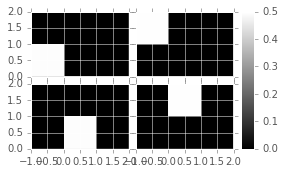

In [32]:
kWidth = 3
kHeight = 2

# create image arrays for the basis kernels
basisImArrList = []
imArr = np.zeros((kWidth, kHeight), dtype=float)
imArr[0,0] = 1
basisImArrList.append(imArr)
imArr = np.zeros((kWidth, kHeight), dtype=float)
imArr[0,1] = 1
basisImArrList.append(imArr)
imArr = np.zeros((kWidth, kHeight), dtype=float)
imArr[1,0] = 1
basisImArrList.append(imArr)
imArr = np.zeros((kWidth, kHeight), dtype=float)
imArr[1,1] = 1
basisImArrList.append(imArr)

# create a list of basis kernels from the images
basisKernelList = afwMath.KernelList()
for basisImArr in basisImArrList:
    basisImage = afwImage.makeImageFromArray(basisImArr.transpose().copy())
    kernel = afwMath.FixedKernel(basisImage)
    basisKernelList.append(kernel)

reload(dit)
dit.plotImageGrid(basisKernelList, clim=(0,0.5))

[1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 0.6570228642997975]


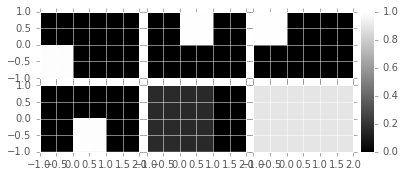

In [56]:
sParams = afwMath.Function2DList()
aScale = 1
sParams.append(afwMath.LanczosFunction2D(aScale, 0., 0.))
sParams.append(afwMath.LanczosFunction2D(aScale, 0., 1.))
sParams.append(afwMath.LanczosFunction2D(aScale, 1., 1.))
sParams.append(afwMath.LanczosFunction2D(aScale, 1., 0.))
kernel = afwMath.LinearCombinationKernel(basisKernelList, sParams)

kImages = []
for colPos, rowPos in [
    (0.0, 0.0),
    (1.0, 0.0),
    (0.0, 1.0),
    (1.0, 1.0),
    (0.5, 0.5),]:
    kImage = afwImage.ImageD(afwGeom.Extent2I(kWidth, kHeight))
    kernel.computeImage(kImage, False, colPos, rowPos)
    kImages.append(kImage)
    kImArr = kImage.getArray().transpose()
    
print [kim.sum() for kim in basisImArrList]
print [kim.getArray().sum() for kim in kImages]

reload(dit)
dit.plotImageGrid(kImages, clim=(0,1))

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1. ]
[  6.15860293e-34   4.84105715e-03   2.21675602e-02   5.48503887e-02
   1.03174091e-01   1.64255716e-01   2.32141705e-01   2.98629894e-01
   3.54680964e-01   3.92125629e-01   4.05284735e-01   3.92125629e-01
   3.54680964e-01   2.98629894e-01   2.32141705e-01   1.64255716e-01
   1.03174091e-01   5.48503887e-02   2.21675602e-02   4.84105715e-03
   6.15860293e-34]
[ 0.65702286]


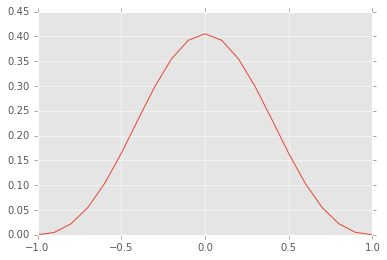

In [67]:
tmp = afwMath.LanczosFunction2D(aScale, 0., 0.)
x = np.linspace(-1.,1.,21)
y = np.array([tmp(xx, 0.5) for xx in x])
print x
print y
print y[x == 0.5] * 4.
plt.plot(x, y)

[ 0.65702286]


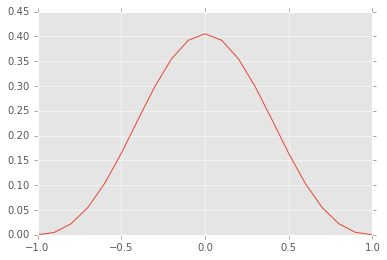

In [70]:
y2 = np.sinc(x) * np.sinc(x/aScale) * (np.sinc(0.5) * np.sinc(0.5/a))
print y2[x == 0.5] * 4.
plt.plot(x, y2)